**Depends**

In [1]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*

import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                            size=(1400, 900))
_ = _display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


**Start**

In [3]:
# import

import gym
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from collections import deque
from IPython import display

In [4]:
# cuda or not

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:",torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla P100-PCIE-16GB


device(type='cuda')

In [5]:
# delta_screen convert to state
import torchvision.transforms as T

"""resize = T.Compose([T.ToPILImage(), T.Resize(160), T.ToTensor()])"""

def convert_to_state(to_crop):
  # crop
  to_crop = 1 - to_crop[:, 160:320, :] / 255

  # memory
  # to_crop = np.ascontiguousarray(to_crop)

  # DPI: only when tensor and normalize, may can't be adopted to quick response env, since low sensitivity to velocity
  """to_crop = resize(torch.tensor(to_crop, dtype=torch.float)).unsqueeze(0)"""  

  return torch.tensor(to_crop, dtype=torch.float).unsqueeze(0)

In [6]:
# XXXX
env = gym.make('CartPole-v1')
env.reset()
x = env.render('rgb_array')

(400, 600, 3)
(3, 400, 600)


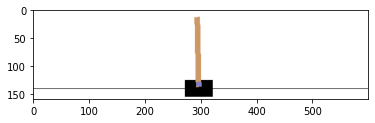

In [7]:
# XXXX
print(x.shape)
plt.imshow(x[160:319,:,:])
print(x.transpose((2,0,1)).shape)

(3, 160, 600)
(160, 600, 3)


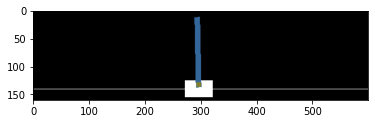

In [8]:
# XXXX
y = convert_to_state(x.transpose((2,0,1))).squeeze(0).cpu().numpy()
print(y.shape)
z = y.transpose((1,2,0))
print(z.shape)
plt.imshow(z)

In [9]:
# replay memory

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)
        pass

    def push(self, state, action, reward, next_state, done):
        """Save a transition"""
        c_state = convert_to_state(state) # c_state is a tensor here
        c_next_state = convert_to_state(next_state) # c_next_state is a tensor here
        self.memory.append((c_state, action, reward, c_next_state, done))
        pass

    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)
        return torch.cat(states, 0), torch.tensor(actions).view(-1,1), torch.tensor(rewards,dtype=torch.float).view(-1,1), torch.cat(next_states, 0), torch.tensor(dones).view(-1,1)
        pass
    def __len__(self):
        return len(self.memory)
        pass      
    
    pass

In [10]:
# DQN

class DQN(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=8, stride=4),
          nn.ReLU(),
          # nn.BatchNorm2d(16),

          nn.Conv2d(32, 64, kernel_size=4, stride=2),
          nn.ReLU(),
          # nn.BatchNorm2d(32),

          nn.Conv2d(64, 64, kernel_size=3, stride=1),
          nn.ReLU(),
          # nn.BatchNorm2d(16),

          nn.Flatten(),

          nn.Linear(72704, 512),
          nn.ReLU(),
          # nn.LayerNorm(128),
          nn.Linear(512, 2),
        )

        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, using simple stochastic gradient descent
        LEARNING_RATE = 1e-4
        self.optimiser = torch.optim.Adam(self.parameters(), LEARNING_RATE)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    def train(self, states, actions, rewards, next_states, dones, target_net):
        GAMMA = 0.99

        Qsa0 = self.forward(states).gather(1, actions)
        Qsa1 = target_net.forward(next_states).max(1)[0].view(-1,1).detach()

        outputs = Qsa0
        targets = rewards + GAMMA*Qsa1*(~dones)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        for param in policy_net.parameters():
          param.grad.data.clamp(-1,1)
        self.optimiser.step()

        pass
       
    def train_count(self):
        return self.counter

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(alpha=0.1, marker='.', grid=True)
        pass
    
    pass

In [11]:
"""Setup"""

env = gym.make('CartPole-v1')

policy_net = DQN()
target_net = DQN()
policy_net.load_state_dict(torch.load('mount/My Drive/Colab Notebooks/cartpole/cartpole_cnn.pth'))
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [12]:
print(policy_net)

DQN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=72704, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=2, bias=True)
  )
  (loss_function): MSELoss()
)


**Train:**
If just want to use existed mode for check, please skip this section

In [40]:
"""Prepare for training"""

EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 200
BATCH_SIZE = 32
REPLAY_IZE = 5000 # memory full when set to 10000
TARGET_UPDATE = 10

memory = ReplayMemory(REPLAY_IZE)

durations = [0,0,0,0,0,0,0,0,0]

CPU times: user 1h 52min 27s, sys: 2min 58s, total: 1h 55min 25s
Wall time: 1h 54min 41s


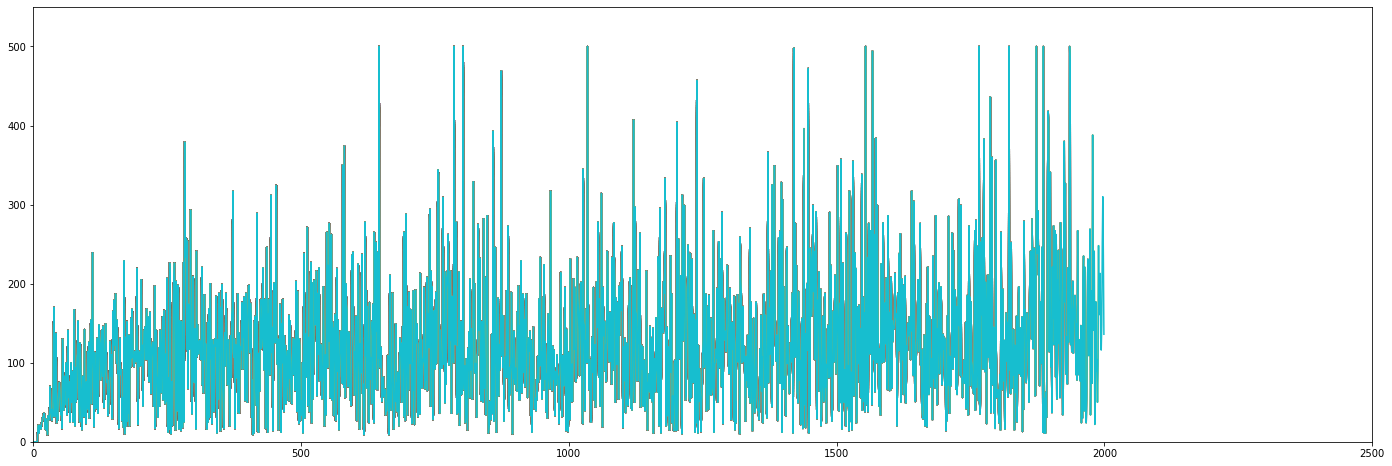

In [41]:
%%time

"""Training the agent"""

num_episodes = 2000
current_episode = 0
to_episode = current_episode + num_episodes + 500

fig = plt.figure(figsize=(24, 8))
ax = plt.axes()
ax.set_xlim([current_episode, to_episode])
ax.set_ylim([0, 550])

for i_episode in range(num_episodes):

  env.reset()

  done = False
  
  x_screen = env.render('rgb_array')
  y_screen = env.render('rgb_array')
  z_screen = env.render('rgb_array')
  state = np.array([x_screen[:,:,2], y_screen[:,:,2], z_screen[:, :, 2]]).squeeze()

  duration = 0

  while not done:

    # sampling

    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * policy_net.train_count() / EPS_DECAY)

    if random.random() < eps_threshold:
      action = env.action_space.sample()
      pass
    else:
      action = policy_net.forward(convert_to_state(state)).argmax().detach().item()
      pass

    _, reward, done, _ = env.step(action)

    x_screen = y_screen
    y_screen = z_screen
    z_screen = env.render('rgb_array')
    next_state = np.array([x_screen[:,:,2], y_screen[:,:,2], z_screen[:, :, 2]]).squeeze()

    memory.push(state, action, reward, next_state, done)
    state = next_state

    duration += 1 

    # training

    if len(memory) < BATCH_SIZE:
      continue

    states, actions, rewards, next_states, dones = memory.sample(BATCH_SIZE)

    policy_net.train(states, actions, rewards, next_states, dones, target_net)

    pass

  # progress

  durations.append(duration)

  # udpate target_net
  # plot progress
  # check if ok to stop

  if i_episode % TARGET_UPDATE == 0:
    target_net.load_state_dict(policy_net.state_dict())

    ax.plot(durations)
    display.display(fig)
    display.clear_output(wait=True)

    if np.mean(durations[-10:-1]) > 475:
      break;
    pass

  pass

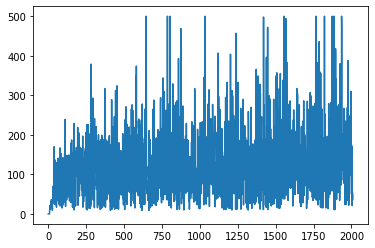

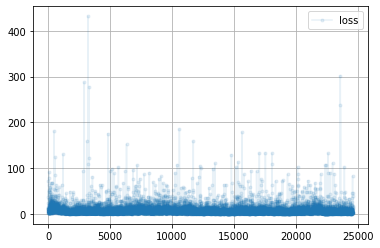

In [42]:
# XXXX

plt.plot(durations)
policy_net.plot_progress()

**XXXXXXXX**

In [66]:
# video record

from gym.wrappers.monitoring.video_recorder import VideoRecorder

after_training = "after_training.mp4"
video = VideoRecorder(env, after_training)

env.reset()

done = False

x_screen = env.render('rgb_array')
y_screen = env.render('rgb_array')
z_screen = env.render('rgb_array')
state = np.array([x_screen[:,:,2], y_screen[:,:,2], z_screen[:, :, 2]]).squeeze()

duration = 0

while not done:
  env.render()
  video.capture_frame()

  action = target_net.forward(convert_to_state(state)).argmax().detach().item()

  _, _, done, _ = env.step(action)

  x_screen = y_screen
  y_screen = z_screen
  z_screen = env.render('rgb_array')
  next_state = np.array([x_screen[:,:,2], y_screen[:,:,2], z_screen[:, :, 2]]).squeeze()

  state = next_state

  duration += 1 
  
  pass

video.close()
env.close()

In [50]:
# video -> html function

from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [67]:
# video play

from IPython.display import HTML
html = render_mp4(after_training)
HTML(html)

**Save**

In [56]:
"""Save model"""

torch.save(target_net.state_dict(), 'mount/My Drive/Colab Notebooks/cartpole/cartpole_cnn.pth')
print("Save completed!")

Save completed!
